# The Wonderful World of Coffee

This notebook begins to explore the retail sales of a cars dataset scraped by one gracious
 reddit user, We will be predicting Price first, but lets see where the day takes us

The data source is below

https://github.com/jldbc/coffee-quality-database

First things first, lets import our libraries and take a peek at our data.


In [1]:
#Add library references
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
#Upload Data

df_arab = pd.read_csv('https://raw.githubusercontent.com/jldbc/coffee-quality-database/master/data/arabica_data_cleaned.csv') # read in the Arabica data
df_rob = pd.read_csv('https://raw.githubusercontent.com/jldbc/coffee-quality-database/master/data/robusta_data_cleaned.csv') # read in the Robusta data
#Quick Column rename
df_arab.rename(columns={'Unnamed: 0':'Id'}, inplace=True)
df_rob.rename(columns={'Unnamed: 0':'Id'}, inplace=True)
print(df_arab.columns)


Index(['Id', 'Species', 'Owner', 'Country.of.Origin', 'Farm.Name',
       'Lot.Number', 'Mill', 'ICO.Number', 'Company', 'Altitude', 'Region',
       'Producer', 'Number.of.Bags', 'Bag.Weight', 'In.Country.Partner',
       'Harvest.Year', 'Grading.Date', 'Owner.1', 'Variety',
       'Processing.Method', 'Aroma', 'Flavor', 'Aftertaste', 'Acidity', 'Body',
       'Balance', 'Uniformity', 'Clean.Cup', 'Sweetness', 'Cupper.Points',
       'Total.Cup.Points', 'Moisture', 'Category.One.Defects', 'Quakers',
       'Color', 'Category.Two.Defects', 'Expiration', 'Certification.Body',
       'Certification.Address', 'Certification.Contact', 'unit_of_measurement',
       'altitude_low_meters', 'altitude_high_meters', 'altitude_mean_meters'],
      dtype='object')


Now that we've got the data inputted, let's begin our EDA process by looking at our datatypes and
overall shape of the data.


In [14]:
#Arabica Stats
#print(df_arab.head().append(df_arab.tail()), "\n")
print("Structure of Arabica:\n",df_arab.shape,"\n")
print("Summary Statistic's:\n",df_arab.describe(),"\n")
print("Count of missing Arabica values:\n",df_arab.isnull().sum().sort_values(ascending=False),"\n")

#Rob Stats
#print(df_rob.head().append(df_arab.tail()), "\n")
print("Structure of Robusta:\n",df_rob.shape,"\n")
print("Summary Statistic's:\n",df_rob.describe(),"\n")
print("Count of missing Robusta values:\n",df_rob.isnull().sum().sort_values(ascending=False),"\n")

#Lets also create a description field and combine the datasets.
df_arab['coffee_category'] = 'Arabica'
df_rob['coffee_category'] = 'Robusta'

# #For loop to reset the id field
# arabmax_ID = df_arab['Id'].idxmax()
# 
# For x in df_rob['Id']:
#     print (x)
#     #df_rob['Id'] = arabmax_ID + 1 
#     
# df_comb = df_arab.append(df_rob)
# df_comb.info()


SyntaxError: invalid syntax (<ipython-input-14-f43ccf139bf4>, line 20)

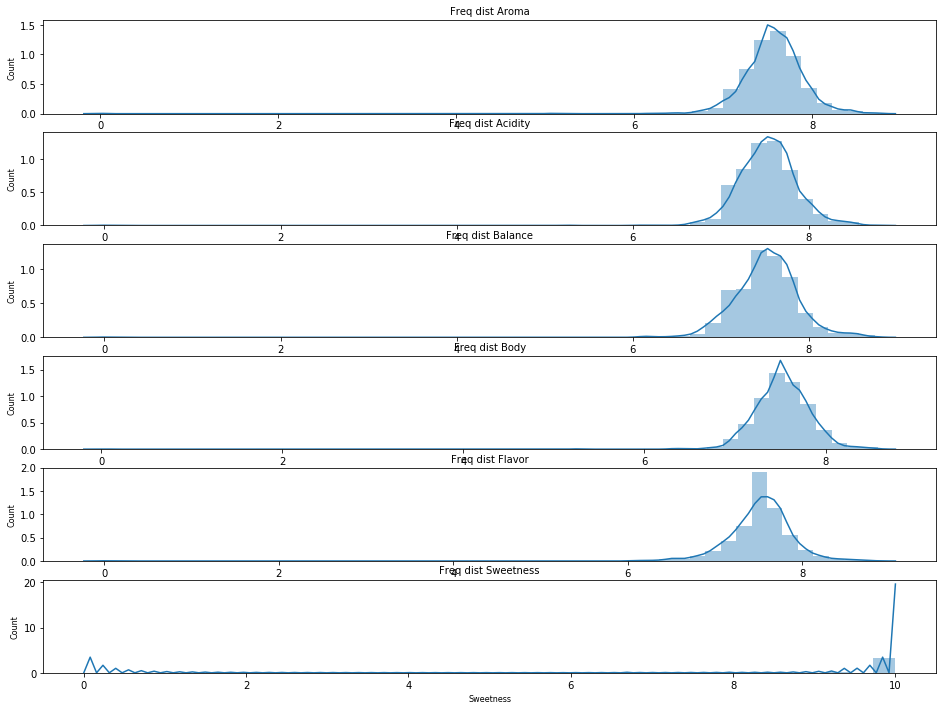

C:\Users\andyh\Anaconda3\envs\miner\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\andyh\Anaconda3\envs\miner\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


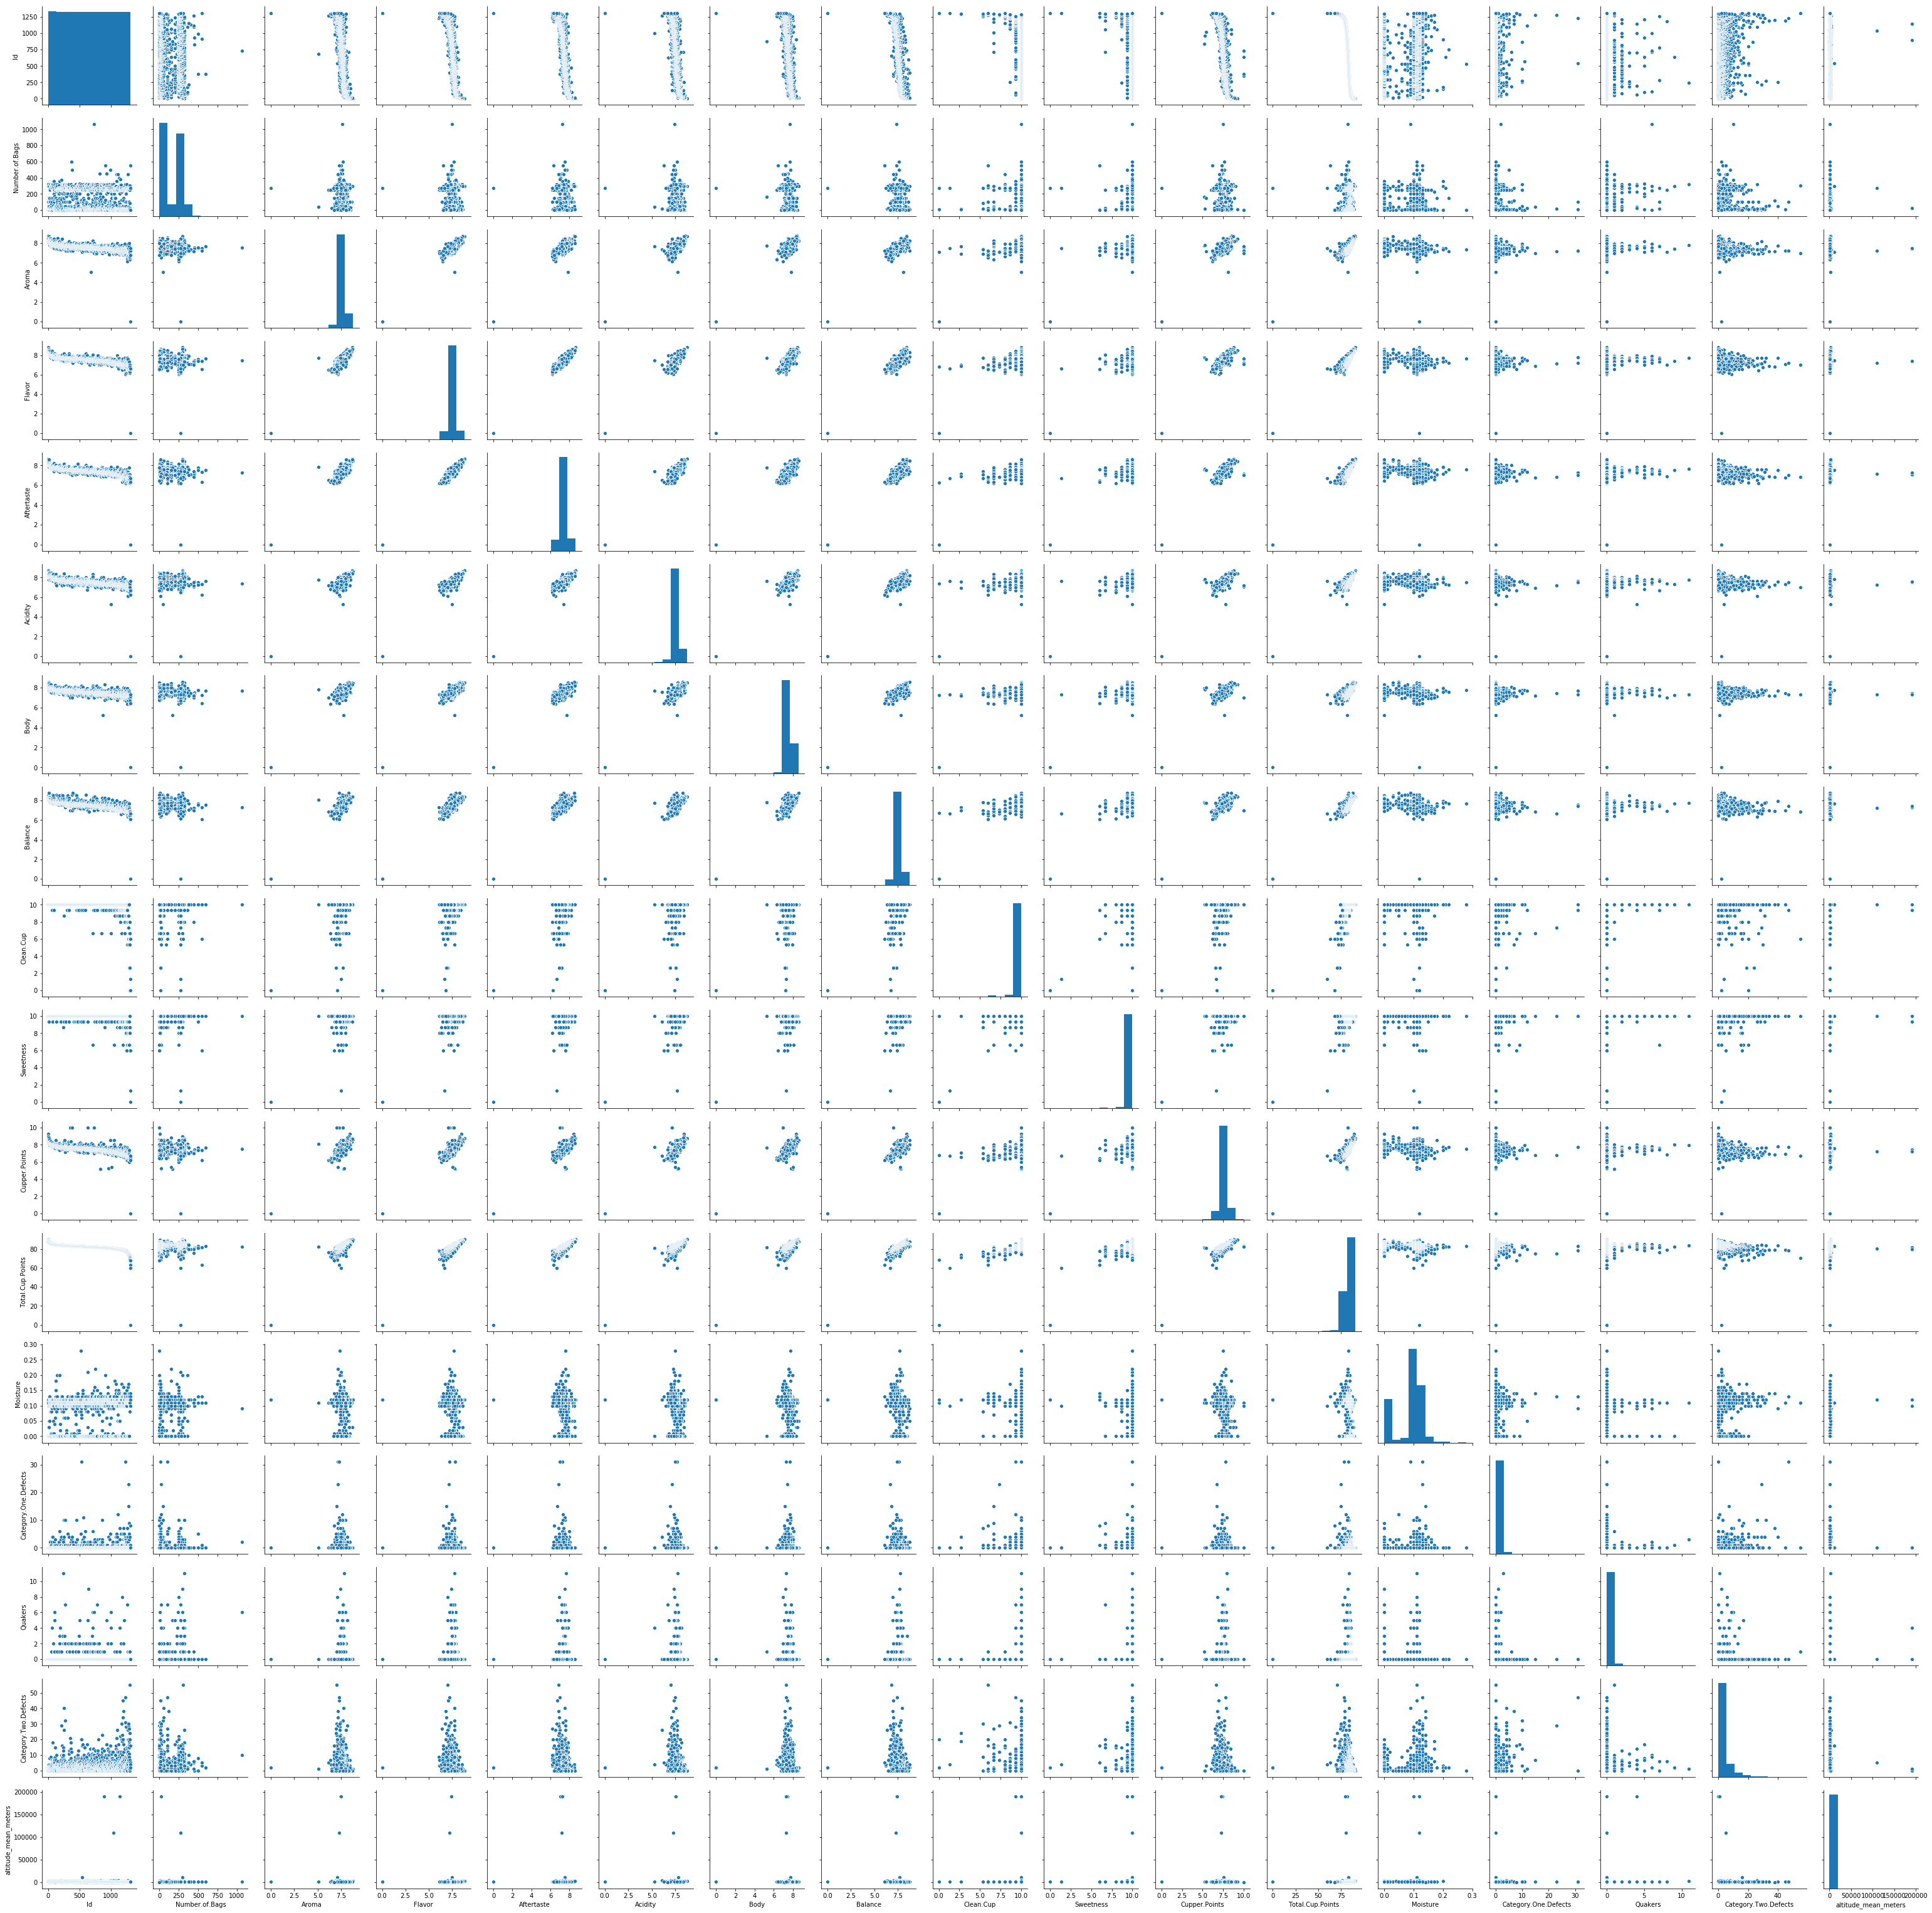

In [4]:
#some initial plots 

col_names = ['Aroma','Acidity', 'Balance', 'Body', 'Flavor', 'Sweetness']

fig, ax = plt.subplots(len(col_names), figsize=(16,12))

for i, col_val in enumerate(col_names):

    sns.distplot(df_arab[col_val], hist=True, ax=ax[i])
    ax[i].set_title('Freq dist '+col_val, fontsize=10)
    ax[i].set_xlabel(col_val, fontsize=8)
    ax[i].set_ylabel('Count', fontsize=8)

plt.show()

#Huge pairplot matrix.  Probably need to whittle down the attributes a bit first.Example drops below

df_arab = df_arab.drop(['Lot.Number', 'altitude_low_meters', 'altitude_high_meters'], axis=1)
sns.pairplot(df_arab)


Well it seems as though we still have too many variables.  Lets divy them up into numerical and
categorical.  


In [ ]:
df_num = df_arab
